In [1]:
# ============================
# Cell 1: Import & 환경 설정
# ============================
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import timm
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score

# 디바이스 및 랜덤 seed
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Seed 고정
import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)
print(f"🖥️ Device: {DEVICE}")
print("✅ 환경 설정 완료!")


🖥️ Device: cuda
✅ 환경 설정 완료!


In [2]:
# ============================
# Cell 2: 하이퍼파라미터
# ============================
IMG_H, IMG_W = 224, 224            # ViT 추천 크기
BATCH_SIZE = 10
EPOCHS = 35
LR = 5e-5
WEIGHT_DECAY = 1e-4

In [3]:
# ============================
# Cell 3: Custom Dataset
# ============================
class DocumentDataset(torch.utils.data.Dataset):
    def __init__(self, img_path, csv_path, img_h, img_w, is_train=True):
        self.img_path = img_path
        self.df = pd.read_csv(csv_path)
        self.is_train = is_train
        self.transform = A.Compose([
            A.Resize(height=img_h, width=img_w),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        id = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]
        img_path = f"{self.img_path}/{id}"
        img = cv2.imread(img_path)
        
        # 이미지 로딩 실패 시 에러 처리
        if img is None:
            raise ValueError(f"이미지를 로드할 수 없습니다: {img_path}")
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(image=img)['image']
        return img, label

In [4]:
# ============================
# Cell 4: DataLoader
# ============================
train_dataset = DocumentDataset(
    img_path='train_aug_50',        # 데이터 경로
    csv_path='train_aug_50.csv',
    img_h=IMG_H,
    img_w=IMG_W,
    is_train=True
)
val_dataset = DocumentDataset(
    img_path='train',
    csv_path='val_split.csv',
    img_h=IMG_H,
    img_w=IMG_W,
    is_train=False
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Train: {len(train_dataset)}개, Val: {len(val_dataset)}개")

Train: 237070개, Val: 314개


In [ ]:
# ============================
# Cell 5: 모델, Optimizer, Loss, Scheduler
# ============================
class ViTClassifier(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', num_classes=17):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    def forward(self, x):
        return self.backbone(x)

model = ViTClassifier().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

: 

In [ ]:
# ============================
# Cell 6: 학습 루프
# ============================
best_f1 = 0.0
train_losses = []
train_f1s = []
train_accs = []
val_f1s = []

patience = 1  # 개선 없을 때 허용할 최대 에포크 수
counter = 0

for epoch in range(EPOCHS):
    try:
        # Train
        model.train()
        epoch_loss = 0.0
        train_preds = []
        train_targets = []
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            # Train 예측 수집
            preds = outputs.argmax(dim=1).cpu().numpy()
            train_preds.extend(preds)
            train_targets.extend(labels.cpu().numpy())
        
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        scheduler.step()
        
        # Train F1, accuracy 계산
        train_f1 = f1_score(train_targets, train_preds, average='macro')
        train_acc = accuracy_score(train_targets, train_preds)
        train_f1s.append(train_f1)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation", leave=False):
                images = images.to(DEVICE)
                outputs = model(images)
                preds = outputs.argmax(dim=1).cpu().numpy()
                val_preds.extend(preds)
                # 레이블을 안전하게 CPU로 이동 후 numpy 변환
                val_targets.extend(labels.cpu().numpy())
        val_f1 = f1_score(val_targets, val_preds, average='macro')
        val_f1s.append(val_f1)
        
        print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss={avg_loss:.4f}, Train F1={train_f1:.4f}, Train Acc={train_acc:.4f}, Val F1={val_f1:.4f}")
        if val_f1 > best_f1:
            best_f1 = val_f1
            model_path = 'best_vit.pth'
            torch.save(model.state_dict(), model_path)
            print(f"  ✅ Best Model Saved! F1={best_f1:.4f} -> {model_path}")

        else:
            counter += 1
            print(f"  ⚠️ EarlyStopping counter: {counter} out of {patience}")
            if counter >= patience:
                print("▶ Early stopping triggered!")
                break
    
    except Exception as e:
        print(f"\n❌ Epoch {epoch+1}에서 에러 발생: {e}")
        print("모델 상태를 저장합니다...")
        torch.save(model.state_dict(), f'vit_checkpoint_epoch_{epoch+1}.pth')
        raise  # 에러를 다시 발생시켜서 사용자가 확인할 수 있도록

print(f"\n🎯 최종 Best Val F1: {best_f1:.4f}")

# 학습 로그 CSV 저장
training_log = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train_loss': train_losses,
    'train_f1': train_f1s,
    'train_acc': train_accs,
    'val_f1': val_f1s
})
training_log.to_csv('vit_training_log.csv', index=False)
print("✅ 학습 로그 저장: vit_training_log.csv")

Epoch 1/35:   7%|▋         | 1715/23707 [07:38<1:37:04,  3.78it/s]

✅ 나눔폰트 설정 완료!


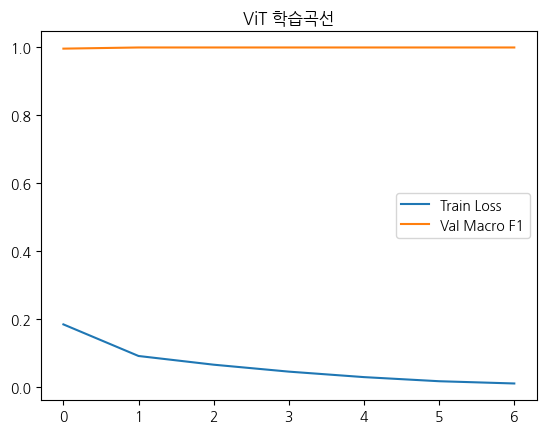

In [ ]:
# ============================
# Cell 7: 시각화
# ============================

# ============================
# 나눔폰트 설정
# ============================
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 폰트 확인
try:
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    if 'NanumGothic' in available_fonts:
        print("✅ 나눔폰트 설정 완료!")
    else:
        print("⚠️ 나눔폰트 미설치!")
        print("   터미널 실행: sudo apt-get install fonts-nanum")
        print("   설치 후 커널 재시작 필요")
except Exception as e:
    print(f"❌ 폰트 설정 오류: {e}")

    
plt.plot(train_losses, label='Train Loss')
plt.plot(val_f1s, label='Val Macro F1')
plt.legend()
plt.title('ViT 학습곡선')
plt.show()

In [ ]:
# ============================
# 결과 요약
# ============================
print("\n" + "="*60)
print("🎯 ViT 학습 결과")
print("="*60)
print(f"  - Best Val F1: {best_f1:.4f}")
print(f"  - 최종 Train Loss: {train_losses[-1]:.4f}")
print(f"  - 최종 Val F1: {val_f1s[-1]:.4f}")
print(f"  - 모델 저장: best_vit.pth")
print("="*60)



🎯 ViT 학습 결과
  - Best Val F1: 1.0000
  - 최종 Train Loss: 0.0117
  - 최종 Val F1: 1.0000
  - 모델 저장: best_vit.pth
